# MLP

In [18]:
!pip install --quiet torch torchvision monai nnunetv2

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import time
import os
import h5py
from skimage.transform import resize
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

In [19]:
IMG_SIZE = 256      # Đảm bảo phù hợp với preprocessing
NUM_CLASSES = 4     # Số lớp segmentation
BATCH_SIZE = 16
LEARNING_RATE = 1e-4
NUM_EPOCHS_CENTRALIZED = 200
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Adaptive_tvmf_dice_loss(nn.Module):
    """
    Adaptive t-vMF Dice Loss cho segmentation đa lớp.
    """
    def __init__(self, num_classes, t=1.0, adaptive=True, smooth=1e-5):
        super().__init__()
        self.num_classes = num_classes
        self.t = t
        self.adaptive = adaptive
        self.smooth = smooth

    def forward(self, logits, targets):
        # logits: (B, C, H, W), targets: (B, H, W)
        probs = F.softmax(logits, dim=1)
        targets_onehot = F.one_hot(targets, num_classes=self.num_classes).permute(0,3,1,2).float()
        
        # Cosine similarity cho từng lớp và từng phần tử trong batch
        probs_flat = probs.view(probs.size(0), self.num_classes, -1)
        targets_flat = targets_onehot.view(targets_onehot.size(0), self.num_classes, -1)
        
        dot = torch.sum(probs_flat * targets_flat, dim=2) 
        probs_norm = torch.norm(probs_flat, dim=2)        
        targets_norm = torch.norm(targets_flat, dim=2)    
        
        cosine = dot / (probs_norm * targets_norm + self.smooth) # Shape: (B, C)
        
        # t-vMF weighting (gamma)
        if self.adaptive:
            class_freq = torch.sum(targets_flat, dim=(0,2)) + self.smooth 
            class_prop = class_freq / class_freq.sum()
            t_per_class = self.t / class_prop 
            t_per_class = t_per_class.clamp(min=0.1, max=10.0) 
            t_per_class = t_per_class.unsqueeze(0) # Shape: (1, C)
        else:
            t_per_class = torch.ones(self.num_classes, device=logits.device) * self.t 
            t_per_class = t_per_class.unsqueeze(0) # Shape: (1, C)
            
        # Tính toán Dice Score chưa có trọng số (dice_score_unweighted hay d_t_vmf)
        dice_score_unweighted = (2 * cosine + self.smooth) / (1 + cosine + self.smooth) # Shape: (B, C)

        # ÁP DỤNG TRỌNG SỐ CHO PHẦN MẤT MÁT CỦA TỪNG LỚP, KHÔNG PHẢI CHO DICE SCORE
        # loss_per_element có dạng (B, C)
        loss_per_element = 1 - dice_score_unweighted 
        
        # Áp dụng trọng số t_per_class (gamma) cho từng phần tử mất mát
        # t_per_class có dạng (1, C), loss_per_element có dạng (B, C)
        weighted_loss_per_element = loss_per_element * t_per_class 
        
        # Lấy trung bình toàn bộ mất mát có trọng số
        loss = weighted_loss_per_element.mean()
        
        return loss

In [21]:
import torch
import torch.nn as nn

class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, dropout=0.1):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Dropout2d(dropout)
        )

    def forward(self, x):
        return self.block(x)

class nnUNet(nn.Module):
    def __init__(self, in_ch=1, num_classes=4, base=32):
        super().__init__()
        self.enc1 = ConvBlock(in_ch, base)
        self.enc2 = ConvBlock(base, base*2)
        self.enc3 = ConvBlock(base*2, base*4)
        self.enc4 = ConvBlock(base*4, base*8)
        self.pool = nn.MaxPool2d(2)
        self.center = ConvBlock(base*8, base*16)
        self.up4 = nn.ConvTranspose2d(base*16, base*8, 2, stride=2)
        self.dec4 = ConvBlock(base*16, base*8)
        self.up3 = nn.ConvTranspose2d(base*8, base*4, 2, stride=2)
        self.dec3 = ConvBlock(base*8, base*4)
        self.up2 = nn.ConvTranspose2d(base*4, base*2, 2, stride=2)
        self.dec2 = ConvBlock(base*4, base*2)
        self.up1 = nn.ConvTranspose2d(base*2, base, 2, stride=2)
        self.dec1 = ConvBlock(base*2, base)
        self.final = nn.Conv2d(base, num_classes, 1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))
        c = self.center(self.pool(e4))
        d4 = self.up4(c)
        d4 = torch.cat([e4, d4], dim=1)
        d4 = self.dec4(d4)
        d3 = self.up3(d4)
        d3 = torch.cat([e3, d3], dim=1)
        d3 = self.dec3(d3)
        d2 = self.up2(d3)
        d2 = torch.cat([e2, d2], dim=1)
        d2 = self.dec2(d2)
        d1 = self.up1(d2)
        d1 = torch.cat([e1, d1], dim=1)
        d1 = self.dec1(d1)
        out = self.final(d1)
        return out


In [22]:
import os
import numpy as np
import h5py
from skimage.transform import resize
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
import random

def load_h5_data(filepath, target_size=(256,256)):
    with h5py.File(filepath, 'r') as f:
        img_data = f['image'][:]
        gt_data = f['label'][:] if 'label' in f else None
        scribble_data = f['scribble'][:] if 'scribble' in f else None

        def proc(d, t_sz, is_mask):
            return resize(
                d.astype(np.uint8 if is_mask else np.float32), t_sz,
                order=0 if is_mask else 1, preserve_range=True,
                anti_aliasing=not is_mask, mode='reflect'
            ).astype(np.uint8 if is_mask else np.float32)

        imgs, masks, scribs = [], [], []
        if img_data.ndim == 3:
            for i in range(img_data.shape[0]):
                imgs.append(np.expand_dims(proc(img_data[i], target_size, False), axis=-1))
                if gt_data is not None:
                    masks.append(proc(gt_data[i], target_size, True))
                if scribble_data is not None:
                    scribs.append(proc(scribble_data[i], target_size, True))
        elif img_data.ndim == 2:
            imgs.append(np.expand_dims(proc(img_data, target_size, False), axis=-1))
            if gt_data is not None:
                masks.append(proc(gt_data, target_size, True))
            if scribble_data is not None:
                scribs.append(proc(scribble_data, target_size, True))
        else:
            raise ValueError(f"Hình ảnh input phải là 2D hoặc 3D, nhận được shape: {img_data.shape}")

        return np.array(imgs), np.array(masks), np.array(scribs)

class CustomACDCDataset(Dataset):
    def __init__(self, data_dir, transform=None, target_size=(256,256), sup_type="label"):
        self.filepaths = [
            os.path.join(data_dir, fname)
            for fname in sorted(os.listdir(data_dir))
            if fname.endswith('.h5')
        ]
        self.transform = transform
        self.target_size = target_size
        self.sup_type = sup_type
        self.slice_indexes = []
        for fi, fpath in enumerate(self.filepaths):
            imgs, masks, scribs = load_h5_data(fpath, target_size)
            n_slice = imgs.shape[0]
            for si in range(n_slice):
                self.slice_indexes.append((fi, si))

    def __len__(self):
        return len(self.slice_indexes)

    def __getitem__(self, idx):
        file_idx, slice_idx = self.slice_indexes[idx]
        filepath = self.filepaths[file_idx]
        imgs, masks, scribs = load_h5_data(filepath, self.target_size)
        image = imgs[slice_idx]
        gt = masks[slice_idx] if len(masks) > 0 else None
        if self.sup_type == "scribble":
            label = scribs[slice_idx] if len(scribs) > 0 else gt
        else:
            label = gt
        sample = {
            "image": image,
            "label": label,
            "gt": gt,
            "scribble": scribs[slice_idx] if len(scribs) > 0 else None,
            "idx": idx
        }
        if self.transform:
            sample = self.transform(sample)
        return sample


In [23]:
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split

# Đường dẫn data training và test (chỉnh đúng đường dẫn trên hệ thống bạn)
train_data_dir = '/kaggle/input/acdc-dataset/ACDC_preprocessed/ACDC_training_slices'
test_data_dir  = '/kaggle/input/acdc-dataset/ACDC_preprocessed/ACDC_testing_volumes'  

# Load toàn bộ ảnh slice và mask từ folder training
img_list, mask_list = [], []
for fname in sorted(os.listdir(train_data_dir)):
    if fname.endswith(".h5"):
        fpath = os.path.join(train_data_dir, fname)
        imgs, msks, _ = load_h5_data(fpath, target_size=(256, 256))
        img_list.append(imgs)
        mask_list.append(msks)

all_imgs = np.concatenate(img_list, axis=0)
all_msks = np.concatenate(mask_list, axis=0)

# Tách 80% train, 20% val
X_train, X_val, y_train, y_val = train_test_split(all_imgs, all_msks, test_size=0.2, random_state=42)

# Chuyển sang TensorDataset cho PyTorch
X_train_tensor = torch.tensor(X_train).permute(0, 3, 1, 2).float()
y_train_tensor = torch.tensor(y_train).long()
X_val_tensor = torch.tensor(X_val).permute(0, 3, 1, 2).float()
y_val_tensor = torch.tensor(y_val).long()

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)


Test image shape: (256, 256, 1) Test label shape: (256, 256)


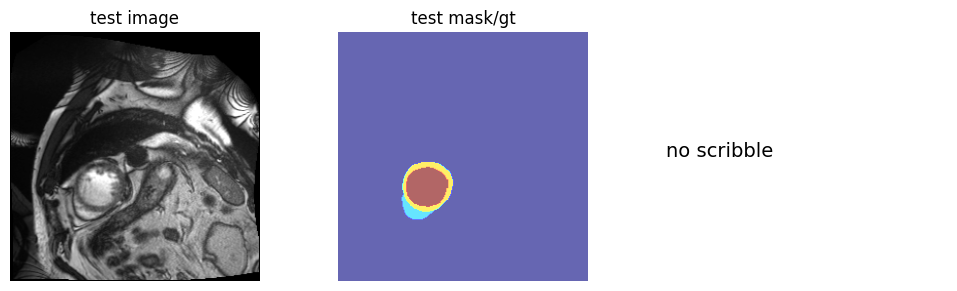

In [24]:
test_dataset = CustomACDCDataset(
    test_data_dir, 
    target_size=(256,256), 
    sup_type="label"
)
BATCH_SIZE = 16  

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
if len(test_dataset) > 0:
    sample = test_dataset[random.randint(0, len(test_dataset)-1)]
    image, label, gt, scribble = sample["image"], sample["label"], sample["gt"], sample["scribble"]
    print("Test image shape:", image.shape, "Test label shape:", label.shape if label is not None else None)

    plt.figure(figsize=(10,3))
    plt.subplot(1,3,1)
    plt.imshow(image.squeeze(), cmap='gray')
    plt.title('test image')
    plt.axis('off')

    plt.subplot(1,3,2)
    if gt is not None:
        plt.imshow(gt.squeeze(), cmap='jet', alpha=0.6)
        plt.title('test mask/gt')
    else:
        plt.text(0.1, 0.5, "no mask", fontsize=14)
    plt.axis('off')

    plt.subplot(1,3,3)
    if scribble is not None:
        plt.imshow(scribble.squeeze(), cmap='jet', alpha=0.6)
        plt.title('test scribble')
    else:
        plt.text(0.1, 0.5, "no scribble", fontsize=14)
    plt.axis('off')

    plt.tight_layout()
    plt.show()
else:
    print("Không tìm thấy dữ liệu test: kiểm tra lại đường dẫn test_data_dir!")


In [25]:
# --- Metrics ---
def evaluate_metrics(model, dataloader, device, num_classes=4):
    model.eval()
    tp = [0] * num_classes
    fp = [0] * num_classes
    fn = [0] * num_classes
    dice_s = [0.0] * num_classes
    iou_s = [0.0] * num_classes
    batches = 0

    with torch.no_grad():
        for imgs,tgts in dataloader:
            imgs,tgts = imgs.to(device),tgts.to(device)
            if imgs.size(0) == 0: continue
            logits = model(imgs)
            preds = torch.argmax(F.softmax(logits,dim=1),dim=1); batches+=1
            for c in range(num_classes):
                pc_f,tc_f=(preds==c).float().view(-1),(tgts==c).float().view(-1); inter=(pc_f*tc_f).sum()
                dice_s[c]+=((2.*inter+1e-6)/(pc_f.sum()+tc_f.sum()+1e-6)).item()
                iou_s[c]+=((inter+1e-6)/(pc_f.sum()+tc_f.sum()-inter+1e-6)).item()
                tp[c]+=inter.item(); fp[c]+=(pc_f.sum()-inter).item(); fn[c]+=(tc_f.sum()-inter).item()
    metrics={'dice_scores':[],'iou':[],'precision':[],'recall':[],'f1_score':[]}
    if batches>0:
        for c in range(num_classes):
            metrics['dice_scores'].append(dice_s[c]/batches); metrics['iou'].append(iou_s[c]/batches)
            prec,rec = tp[c]/(tp[c]+fp[c]+1e-6), tp[c]/(tp[c]+fn[c]+1e-6)
            metrics['precision'].append(prec); metrics['recall'].append(rec)
            metrics['f1_score'].append(2*prec*rec/(prec+rec+1e-6) if (prec+rec > 0) else 0.0)
    else: 
        for _ in range(num_classes): [metrics[key].append(0.0) for key in metrics]
    return metrics

In [ ]:
import os
import sys
import torch
import numpy as np
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split

if __name__ == "__main__":
    print(f"Device: {DEVICE}")

    base_dataset_root = "/kaggle/input/acdc-dataset/ACDC_preprocessed"
    train_data_path = os.path.join(base_dataset_root, "ACDC_training_slices")
    test_data_path  = os.path.join(base_dataset_root, "ACDC_testing_volumes")

    if not os.path.exists(train_data_path) or not os.listdir(train_data_path):
        print(f"Path '{train_data_path}' not found or empty. Using DUMMY data.", file=sys.stderr)
        X_train_tensor = torch.randn(100, 1, IMG_SIZE, IMG_SIZE)
        y_train_tensor = torch.randint(0, NUM_CLASSES, (100, IMG_SIZE, IMG_SIZE))
        X_val_tensor   = torch.randn(20, 1, IMG_SIZE, IMG_SIZE)
        y_val_tensor   = torch.randint(0, NUM_CLASSES, (20, IMG_SIZE, IMG_SIZE))
        X_test_tensor  = torch.randn(30, 1, IMG_SIZE, IMG_SIZE)
        y_test_tensor  = torch.randint(0, NUM_CLASSES, (30, IMG_SIZE, IMG_SIZE))
    else:
        print(f"Loading training data from: {train_data_path}")
        from tqdm import tqdm

        img_list, msk_list = [], []
        for fname in tqdm(sorted(os.listdir(train_data_path))):
            if fname.endswith(".h5"):
                fpath = os.path.join(train_data_path, fname)
                imgs, msks, _ = load_h5_data(fpath, target_size=(IMG_SIZE, IMG_SIZE))
                img_list.append(imgs)
                msk_list.append(msks)
        all_train_images_np = np.concatenate(img_list, axis=0)
        all_train_masks_np  = np.concatenate(msk_list, axis=0) if msk_list and msk_list[0] is not None else None

        if all_train_masks_np is None:
            raise ValueError("Training masks are None. They are required for training.")
        print(f"Loaded total {all_train_images_np.shape[0]} training slices.")

        # --- Load test ---
        img_list, msk_list = [], []
        if os.path.exists(test_data_path) and os.listdir(test_data_path):
            for fname in tqdm(sorted(os.listdir(test_data_path))):
                if fname.endswith(".h5"):
                    fpath = os.path.join(test_data_path, fname)
                    imgs, msks, _ = load_h5_data(fpath, target_size=(IMG_SIZE, IMG_SIZE))
                    img_list.append(imgs)
                    msk_list.append(msks)
            all_test_images_np = np.concatenate(img_list, axis=0) if img_list else np.empty((0, IMG_SIZE, IMG_SIZE, 1))
            all_test_masks_np  = np.concatenate(msk_list, axis=0) if msk_list and msk_list[0] is not None else None
            print(f"Loaded total {all_test_images_np.shape[0]} testing slices.")
        else:
            all_test_images_np = np.empty((0, IMG_SIZE, IMG_SIZE, 1))
            all_test_masks_np  = None

        # --- Normalize ---
        if np.max(all_train_images_np) > 0:
            all_train_images_np = all_train_images_np / np.max(all_train_images_np)
        if all_test_images_np.shape[0] > 0 and np.max(all_test_images_np) > 0:
            all_test_images_np = all_test_images_np / np.max(all_test_images_np)

        # --- Chia validation từ training ---
        X_train_np, X_val_np, y_train_np, y_val_np = train_test_split(
            all_train_images_np, all_train_masks_np, test_size=0.2, random_state=42
        )

        # Convert to Tensor (Bx1HxW)
        X_train_tensor = torch.tensor(X_train_np).permute(0, 3, 1, 2).float()
        y_train_tensor = torch.tensor(y_train_np).long()
        X_val_tensor   = torch.tensor(X_val_np).permute(0, 3, 1, 2).float()
        y_val_tensor   = torch.tensor(y_val_np).long()
        X_test_tensor  = torch.tensor(all_test_images_np).permute(0, 3, 1, 2).float()
        if all_test_masks_np is not None:
            y_test_tensor = torch.tensor(all_test_masks_np).long()
        else:
            y_test_tensor = None

    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset   = TensorDataset(X_val_tensor, y_val_tensor)
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=DEVICE.type=="cuda")
    val_dataloader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=DEVICE.type=="cuda")
    if y_test_tensor is not None:
        test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    else:
        test_dataset = TensorDataset(X_test_tensor)
    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=DEVICE.type=="cuda")

    print(f"\nTraining samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}, Testing samples: {len(test_dataset)}")
    print("Data loaded and prepared for centralized training.")

    # --- MODEL & TRAINING ---
    model = nnUNet(in_ch=1, num_classes=NUM_CLASSES).to(DEVICE)
    criterion = Adaptive_tvmf_dice_loss(num_classes=NUM_CLASSES).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

    best_val_metric = 0.0
    for epoch in range(NUM_EPOCHS_CENTRALIZED):
        print(f"\n--- Epoch {epoch + 1}/{NUM_EPOCHS_CENTRALIZED} ---")
        model.train()
        epoch_train_loss, num_train_batches = 0.0, 0
        for images, targets in train_dataloader:
            images, targets = images.to(DEVICE), targets.to(DEVICE)
            optimizer.zero_grad()
            logits = model(images)
            loss = criterion(logits, targets)
            loss.backward()
            optimizer.step()
            epoch_train_loss += loss.item()
            num_train_batches += 1
        avg_train_loss = epoch_train_loss / num_train_batches if num_train_batches else 0
        print(f"   Epoch {epoch+1} - Train Loss: {avg_train_loss:.4f}")

        if val_dataloader.dataset and len(val_dataloader.dataset) > 0:
            print("   Evaluating on validation set...")
            val_metrics = evaluate_metrics(model, val_dataloader, DEVICE, NUM_CLASSES)
            fg_dice = val_metrics['dice_scores'][1:] if NUM_CLASSES > 1 else [val_metrics['dice_scores'][0]]
            fg_iou  = val_metrics['iou'][1:]         if NUM_CLASSES > 1 else [val_metrics['iou'][0]]
            fg_precision = val_metrics['precision'][1:] if NUM_CLASSES > 1 else [val_metrics['precision'][0]]
            fg_recall    = val_metrics['recall'][1:]    if NUM_CLASSES > 1 else [val_metrics['recall'][0]]
            fg_f1        = val_metrics['f1_score'][1:]  if NUM_CLASSES > 1 else [val_metrics['f1_score'][0]]

            avg_fg_dice = np.mean(fg_dice)
            avg_fg_iou  = np.mean(fg_iou)
            avg_fg_precision = np.mean(fg_precision)
            avg_fg_recall   = np.mean(fg_recall)
            avg_fg_f1       = np.mean(fg_f1)

            print(f"   Epoch {epoch+1} - Validation (Avg Foreground): "
                  f"Dice: {avg_fg_dice:.4f}; IoU: {avg_fg_iou:.4f}; "
                  f"Precision: {avg_fg_precision:.4f}; Recall: {avg_fg_recall:.4f}; F1-score: {avg_fg_f1:.4f}")
            for c_idx in range(NUM_CLASSES):
                print(f"     Class {c_idx}: Dice: {val_metrics['dice_scores'][c_idx]:.4f}; "
                      f"IoU: {val_metrics['iou'][c_idx]:.4f}; "
                      f"Precision: {val_metrics['precision'][c_idx]:.4f}; "
                      f"Recall: {val_metrics['recall'][c_idx]:.4f}; "
                      f"F1-score: {val_metrics['f1_score'][c_idx]:.4f}")
            if avg_fg_dice > best_val_metric:
                best_val_metric = avg_fg_dice
                # torch.save(model.state_dict(), "best_centralized_model.pth")
        else:
            print("   Validation dataset is empty. Skipping validation.")

    print("\n--- Centralized Training Finished ---")


Device: cuda
Loading training data from: /kaggle/input/acdc-dataset/ACDC_preprocessed/ACDC_training_slices


100%|██████████| 1912/1912 [00:29<00:00, 65.33it/s]


Loaded total 1912 training slices.


100%|██████████| 100/100 [00:06<00:00, 16.41it/s]


Loaded total 1076 testing slices.

Training samples: 1529, Validation samples: 383, Testing samples: 1076
Data loaded and prepared for centralized training.

--- Epoch 1/200 ---
   Epoch 1 - Train Loss: 4.9122
   Evaluating on validation set...
   Epoch 1 - Validation (Avg Foreground): Dice: 0.3630; IoU: 0.2450; Precision: 0.2547; Recall: 0.8790; F1-score: 0.3634
     Class 0: Dice: 0.6982; IoU: 0.5368; Precision: 0.9997; Recall: 0.5368; F1-score: 0.6985
     Class 1: Dice: 0.0489; IoU: 0.0251; Precision: 0.0250; Recall: 0.8657; F1-score: 0.0487
     Class 2: Dice: 0.4801; IoU: 0.3173; Precision: 0.3320; Recall: 0.8663; F1-score: 0.4801
     Class 3: Dice: 0.5600; IoU: 0.3925; Precision: 0.4069; Recall: 0.9049; F1-score: 0.5614

--- Epoch 2/200 ---
   Epoch 2 - Train Loss: 3.5613
   Evaluating on validation set...
   Epoch 2 - Validation (Avg Foreground): Dice: 0.5339; IoU: 0.4348; Precision: 0.4687; Recall: 0.9253; F1-score: 0.5349
     Class 0: Dice: 0.7128; IoU: 0.5542; Precision: 1

In [ ]:
# --- Evaluate on Test Set ---
if 'test_dataloader' in locals() and len(test_dataloader.dataset) > 0:
    print("\n--- Evaluating on Test Set ---")
    test_metrics = evaluate_metrics(model, test_dataloader, DEVICE, NUM_CLASSES)

    fg_dice = test_metrics['dice_scores'][1:] if NUM_CLASSES > 1 else [test_metrics['dice_scores'][0]]
    fg_iou = test_metrics['iou'][1:] if NUM_CLASSES > 1 else [test_metrics['iou'][0]]
    fg_precision = test_metrics['precision'][1:] if NUM_CLASSES > 1 else [test_metrics['precision'][0]]
    fg_recall = test_metrics['recall'][1:] if NUM_CLASSES > 1 else [test_metrics['recall'][0]]
    fg_f1 = test_metrics['f1_score'][1:] if NUM_CLASSES > 1 else [test_metrics['f1_score'][0]]

    print(f"  Test (Avg Foreground): "
          f"Dice: {np.mean(fg_dice):.4f}; IoU: {np.mean(fg_iou):.4f}; "
          f"Precision: {np.mean(fg_precision):.4f}; Recall: {np.mean(fg_recall):.4f}; "
          f"F1-score: {np.mean(fg_f1):.4f}")
    
    for c_idx in range(NUM_CLASSES):
        print(f"    Class {c_idx}: "
              f"Dice: {test_metrics['dice_scores'][c_idx]:.4f}; "
              f"IoU: {test_metrics['iou'][c_idx]:.4f}; "
              f"Precision: {test_metrics['precision'][c_idx]:.4f}; "
              f"Recall: {test_metrics['recall'][c_idx]:.4f}; "
              f"F1-score: {test_metrics['f1_score'][c_idx]:.4f}")
else:
    print("Test dataset not available or empty.")